In [1]:
%%capture
!pip install torch-snippets==0.499.16

In [2]:
import os
if not os.path.exists('images'):
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d sshikamaru/car-object-detection
    !unzip -qq car-object-detection.zip
    !rm car-object-detection.zip

Saving kaggle.json to kaggle.json
kaggle.json
 79% 89.0M/112M [00:00<00:00, 322MB/s]
100% 112M/112M [00:00<00:00, 320MB/s] 


In [3]:
from torch_snippets import *
from PIL import Image
import glob
IMAGE_ROOT = '/content/data/training_images'
DF_RAW = df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
H, W , _ =  np.array(Image.open('/content/data/training_images/vid_4_28320.jpg').convert('RGB')).shape

In [4]:
df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
df[['xmin' , 'ymin' , 'xmax' , 'ymax']]  /=  [W , H , W , H] 
df = df.rename(columns={'image' : 'ImageID'})

In [6]:
label2target = {'car' : 1}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [7]:
label2target

{'car': 1, 'background': 0}

In [8]:
target2label

{1: 'car', 0: 'background'}

In [9]:
background_class

0

In [10]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [11]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = ['car'] * len(data)
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)
     

In [12]:

from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features # number of input channels
                                                    , num_classes)
  return model

In [15]:
model = get_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [17]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [18]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix , inputs in enumerate(train_loader):
    loss , losses = train_batch(inputs , model , optimizer)
    loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
    pos = (epoch + (ix+1)/_n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    

  for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
  if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000  val_loc_loss: 0.045  trn_loss: 0.221  trn_loc_loss: 0.063  trn_regr_loss: 0.152  val_loss: 0.168  val_rpn_box_reg_loss: 0.003  val_objectness_loss: 0.001  trn_objectness_loss: 0.002  val_regr_loss: 0.119  trn_rpn_box_reg_loss: 0.003  (70.82s - 283.29s remaining)
EPOCH: 2.000  val_loc_loss: 0.042  trn_loss: 0.148  trn_loc_loss: 0.037  trn_regr_loss: 0.108  val_loss: 0.161  val_rpn_box_reg_loss: 0.003  val_objectness_loss: 0.001  trn_objectness_loss: 0.001  val_regr_loss: 0.115  trn_rpn_box_reg_loss: 0.002  (135.30s - 202.95s remaining)
EPOCH: 3.000  val_loc_loss: 0.042  trn_loss: 0.124  trn_loc_loss: 0.032  trn_regr_loss: 0.089  val_loss: 0.157  val_rpn_box_reg_loss: 0.002  val_objectness_loss: 0.001  trn_objectness_loss: 0.000  val_regr_loss: 0.111  trn_rpn_box_reg_loss: 0.002  (199.85s - 133.23s remaining)
EPOCH: 4.000  val_loc_loss: 0.042  trn_loss: 0.110  trn_loc_loss: 0.027  trn_regr_loss: 0.081  val_loss: 0.150  val_rpn_box_reg_loss: 0.002  val_objectness_loss: 0.001

In [19]:
from torchvision.ops import nms
def decode_output(output):
  bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
  labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
  confs = output['scores'].cpu().detach().numpy()
  ixs = nms(torch.tensor(bbs.astype(np.float32)) , torch.tensor(confs) , 0.05)
  bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

  if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
  return bbs.tolist(), confs.tolist(), labels.tolist()
     


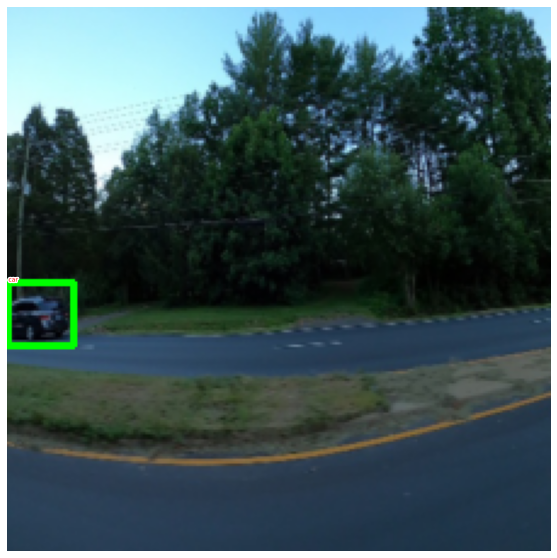

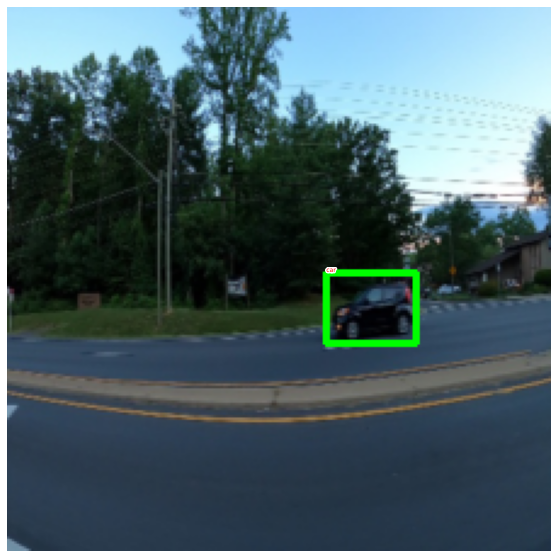

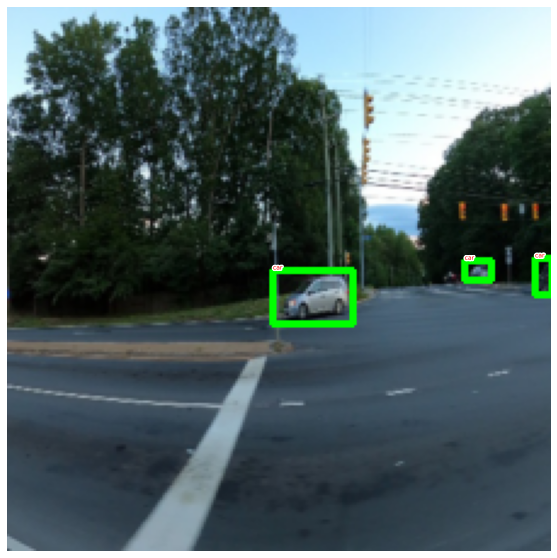

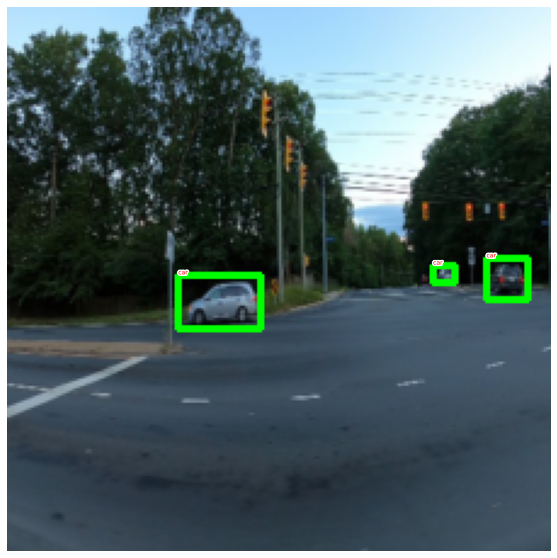

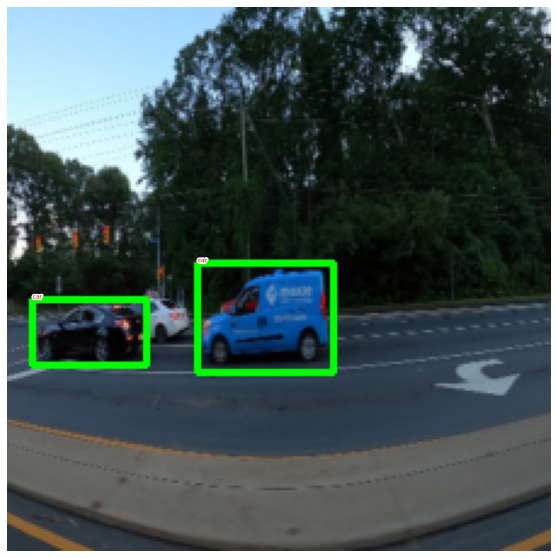

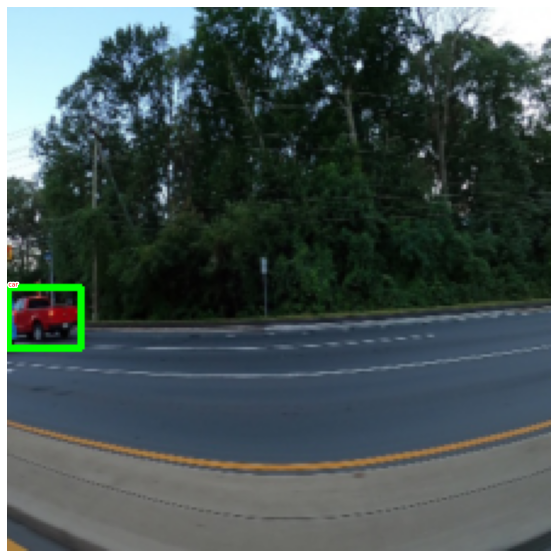

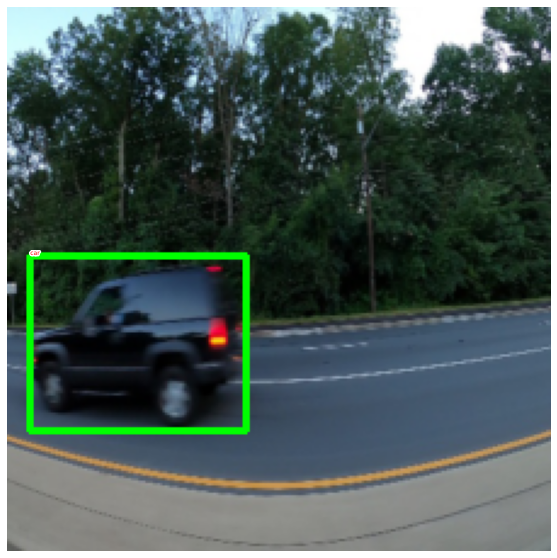

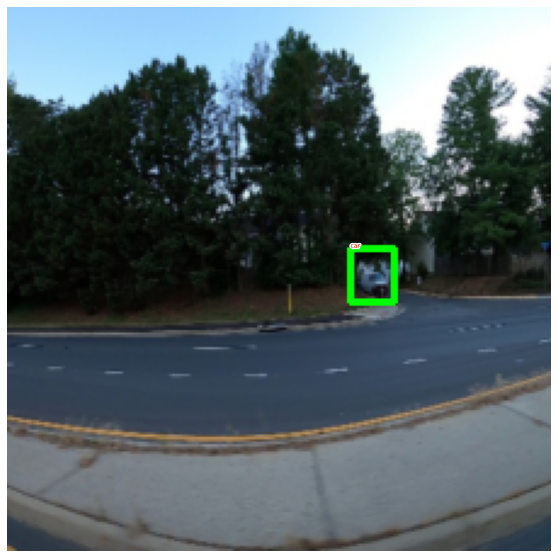

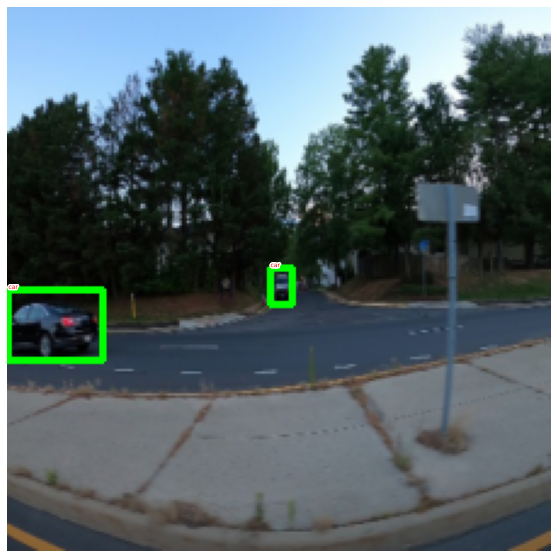

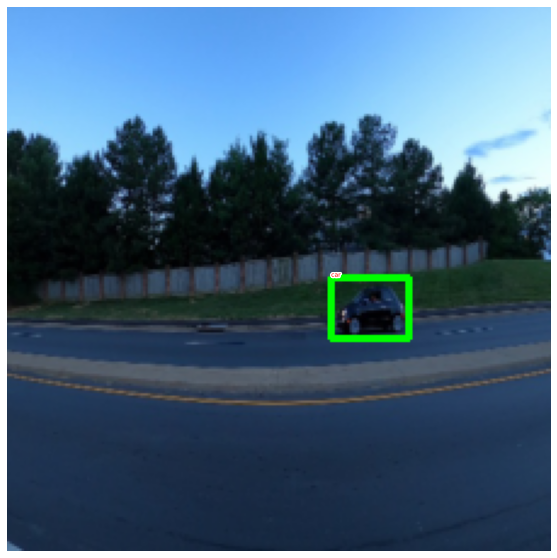

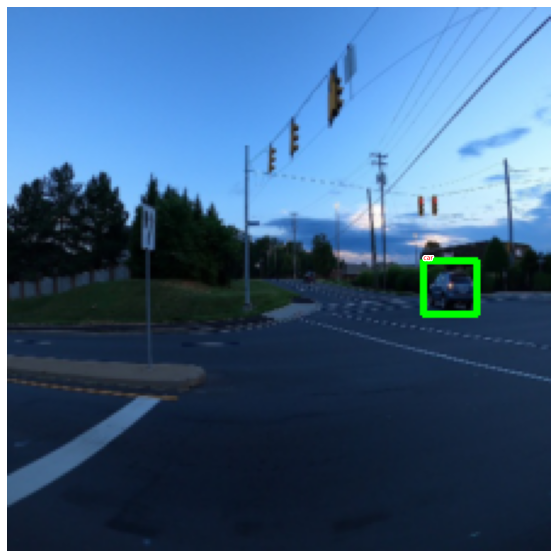

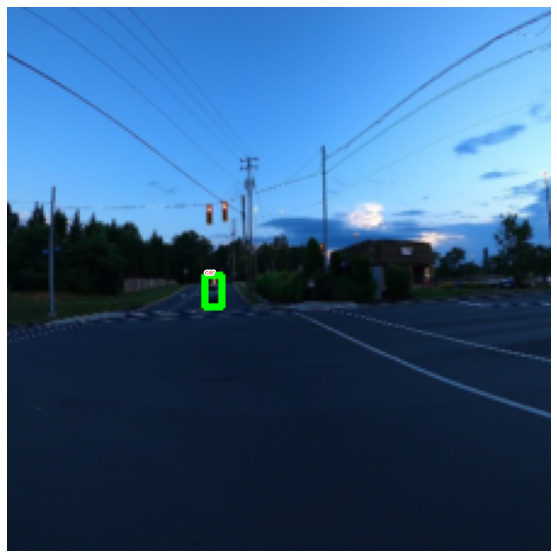

In [20]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=10)